In [1]:
import numpy as np
# Google Play Dataset - Preprocessing

# %%
import pandas as pd
df = pd.read_csv('../Google-Playstore.csv')

In [2]:
# %%
from prettytable import PrettyTable
import random
random.seed(5805)

feature_outlook = PrettyTable()
feature_outlook.field_names = ["Feature", "Type", "N/A Count", "N/A Percentage", "Cat/Num", "Unique Count", "Unique Percentage", "Example"]

def judge_cat_num(col):
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':
        return 'Numerical'
    else:
        return 'Categorical'
    
def check_na_percentage(col):
    ratio = df[col].isna().sum()/len(df[col])
    return f"{ratio:.2%}"

def check_unique_percentage(col):
    ratio = len(df[col].unique())/len(df[col])
    return f"{ratio:.2%}"


for col in df.columns:
    feature_outlook.add_row([col, df[col].dtype, df[col].isna().sum(), check_na_percentage(col), judge_cat_num(col) ,len(df[col].unique()), check_unique_percentage(col), df[col].unique()[random.randint(0, len(df[col].unique())-1)]])
print(feature_outlook)



+-------------------+---------+-----------+----------------+-------------+--------------+-------------------+----------------------------------------------+
|      Feature      |   Type  | N/A Count | N/A Percentage |   Cat/Num   | Unique Count | Unique Percentage |                   Example                    |
+-------------------+---------+-----------+----------------+-------------+--------------+-------------------+----------------------------------------------+
|      App Name     |  object |     5     |     0.00%      | Categorical |   2177944    |       94.16%      |                   駕駛管理                   |
|       App Id      |  object |     0     |     0.00%      | Categorical |   2312944    |      100.00%      | com.mecartec.mejoreshistoriasdeterrorymiedo  |
|      Category     |  object |     0     |     0.00%      | Categorical |      48      |       0.00%       |                 Productivity                 |
|       Rating      | float64 |   22883   |     0.99%      |  

In [3]:
# Numeric features
numeric_describe = PrettyTable()
numeric_describe.field_names = ["Feature", "Mean", "Std", "Min", "25%", "50%", "75%", "Max"]
for col in df.columns:
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':
        numeric_describe.add_row([col, df[col].mean(), df[col].std(), df[col].min(), df[col].quantile(0.25), df[col].quantile(0.5), df[col].quantile(0.75), df[col].max()])
numeric_describe.float_format = '.3'
print(numeric_describe)
# print(df.describe())

+------------------+------------+--------------+-------+--------+---------+----------+-----------------+
|     Feature      |    Mean    |     Std      |  Min  |  25%   |   50%   |   75%    |       Max       |
+------------------+------------+--------------+-------+--------+---------+----------+-----------------+
|      Rating      |   2.203    |    2.106     | 0.000 | 0.000  |  2.900  |  4.300   |      5.000      |
|   Rating Count   |  2864.839  |  212162.571  | 0.000 | 0.000  |  6.000  |  42.000  |  138557570.000  |
| Minimum Installs | 183445.214 | 15131439.060 | 0.000 | 50.000 | 500.000 | 5000.000 | 10000000000.000 |
| Maximum Installs | 320201.713 | 23554954.887 |   0   | 84.000 | 695.000 | 7354.000 |   12057627016   |
|      Price       |   0.103    |    2.633     | 0.000 | 0.000  |  0.000  |  0.000   |     400.000     |
+------------------+------------+--------------+-------+--------+---------+----------+-----------------+


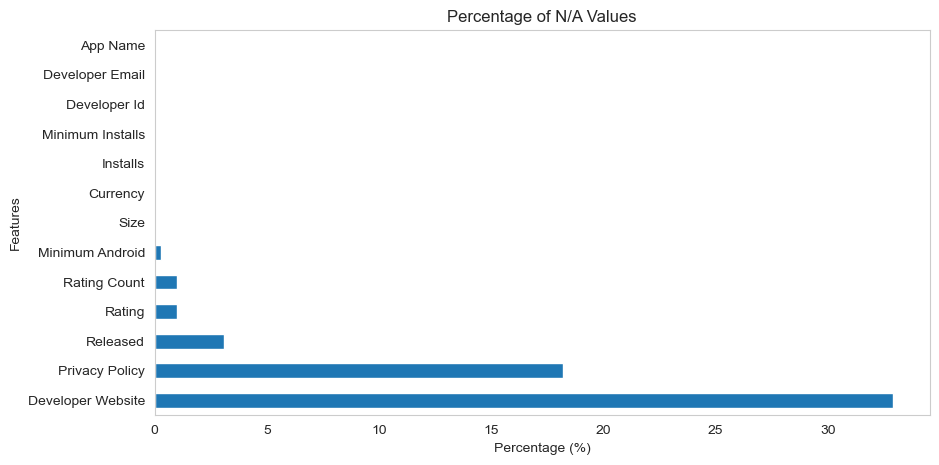

In [4]:
import matplotlib.pyplot as plt
na_feature_percentage = df.isna().sum().sort_values(ascending=False)/len(df) * 100
na_feature_percentage = na_feature_percentage[na_feature_percentage > 0]
plt.figure(figsize=(10, 5))
na_feature_percentage.plot(kind='barh')
plt.xlabel('Percentage (%)')
plt.ylabel('Features')
plt.title('Percentage of N/A Values')
plt.grid()
plt.show()

### Chapter 2 Feature Engineering

In [5]:
# Original shape
print(df.shape)

(2312944, 24)


In [6]:
# Currency distribution
currency_values_count = df['Currency'].value_counts()
print(currency_values_count)

Currency
USD    2311548
XXX       1236
EUR          6
INR          5
GBP          3
CAD          2
VND          1
BRL          1
KRW          1
TRY          1
RUB          1
SGD          1
AUD          1
PKR          1
ZAR          1
Name: count, dtype: int64


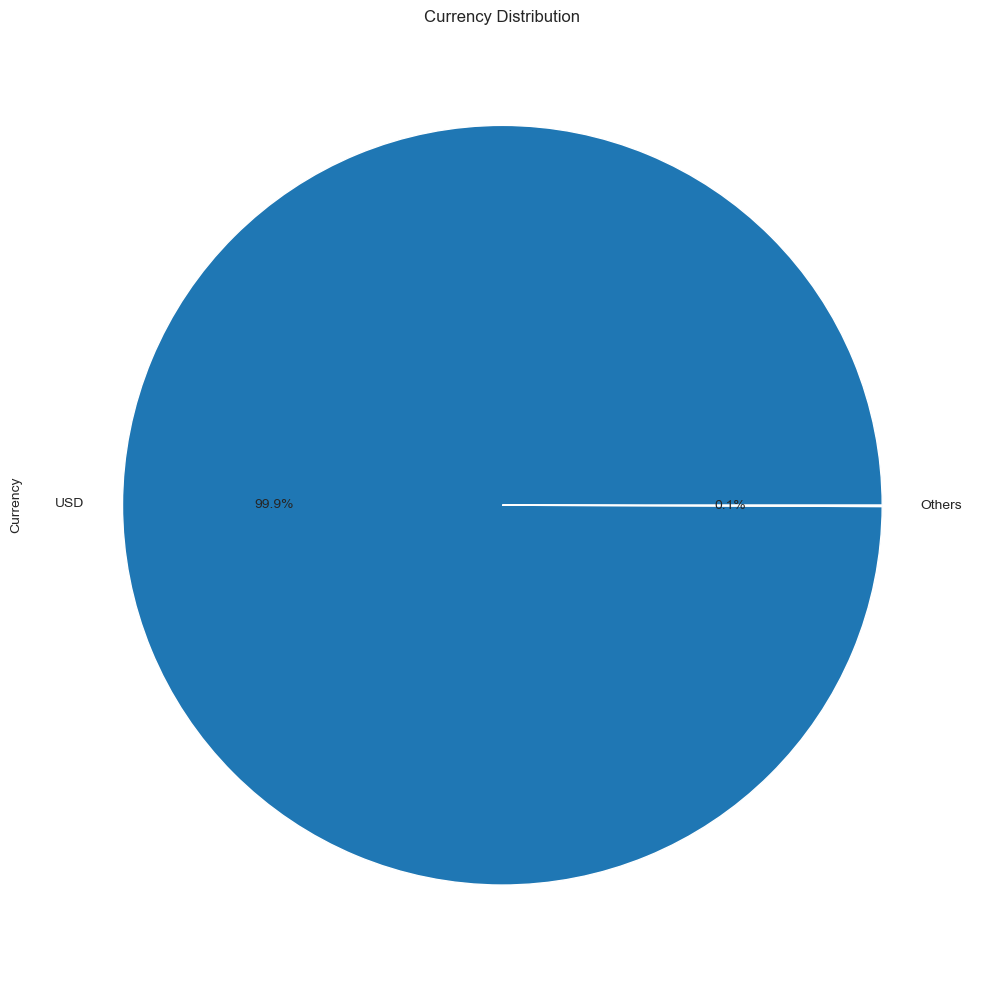

In [7]:
# Currency Distribution - Pie Chart
currency_pie = currency_values_count.head(1)
currency_pie['Others'] = currency_values_count[1:].sum()
currency_pie.plot(kind='pie', figsize=(10, 10), autopct='%1.1f%%', labels=['USD', 'Others'], ylabel='Currency', title='Currency Distribution')
plt.tight_layout()
plt.show()

In [8]:
# Drop all non-USD currency
df['Currency'] = df['Currency'].apply(lambda x: 'USD' if x == 'USD' else 'Others')
df.drop(df[df['Currency'] == 'Others'].index, inplace=True)
print(df.shape)

(2311548, 24)


In [9]:
# Test if installs and min-install are the same
installs = df['Installs'].apply(lambda x: x.replace('+', '') if '+' in x else x)
installs = pd.to_numeric(installs.apply(lambda x: x.replace(',', '') if ',' in x else x))
min_installs = df['Minimum Installs']
min_installs = pd.to_numeric(min_installs)
min_installs = min_installs.astype('int64')
print(installs.equals(min_installs))

True


In [10]:
print(df.shape)

(2311548, 24)


10M
<class 'str'>
24M
<class 'str'>


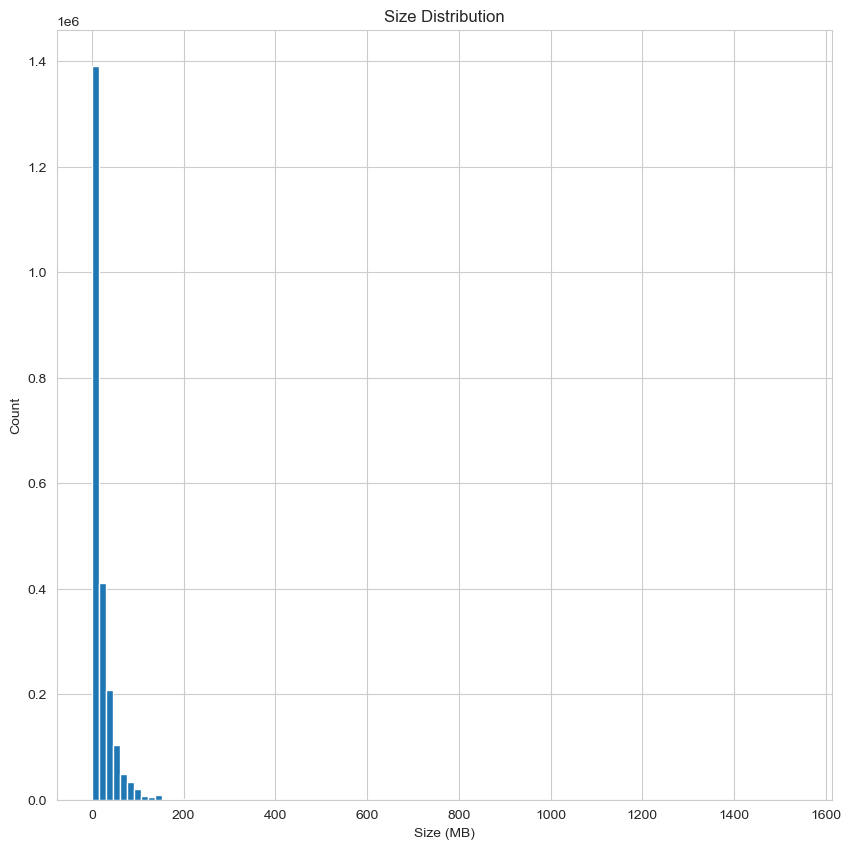

In [11]:
# Working with different unit in Size
print(df['Size'][0])
print(type(df['Size'][0]))
print(str(df['Size'][20]))
print(type(df['Size'][20]))

import numpy as np

import re

def classify_size_column(value):
    if pd.isna(value) or value == 'Varies with device':
        return np.nan
    match = re.search(r'([0-9.]+)([kMG]?)', str(value))
    if match:
        number, unit = match.groups()
        if unit == 'k':
            return float(number) / 1024
        elif unit == 'G':
            return float(number) * 1024
        else:
            return float(number)
    else:
        return np.nan
    
df['Clean Size'] = df['Size'].apply(classify_size_column)
df['Clean Size'].describe()
plt.figure(figsize=(10, 10))
df['Clean Size'].plot(kind='hist', bins=100)
plt.title('Size Distribution')
plt.xlabel('Size (MB)')
plt.ylabel('Count')
plt.show()

In [12]:
# Minimum Android Version
# Replace ' and up' and ' - ' in the entire column
df['Minimum Android'] = df['Minimum Android'].str.replace(' and up', '').str.split(' - ').str.get(0)

In [13]:
df['Minimum Android'].describe()

count     2305025
unique         27
top           4.1
freq       604210
Name: Minimum Android, dtype: object

In [14]:
df['Major Version'] = df['Minimum Android'].str.split('.').str.get(0)

In [15]:
df['Major Version'].describe()

count     2305025
unique          9
top             4
freq      1498030
Name: Major Version, dtype: object

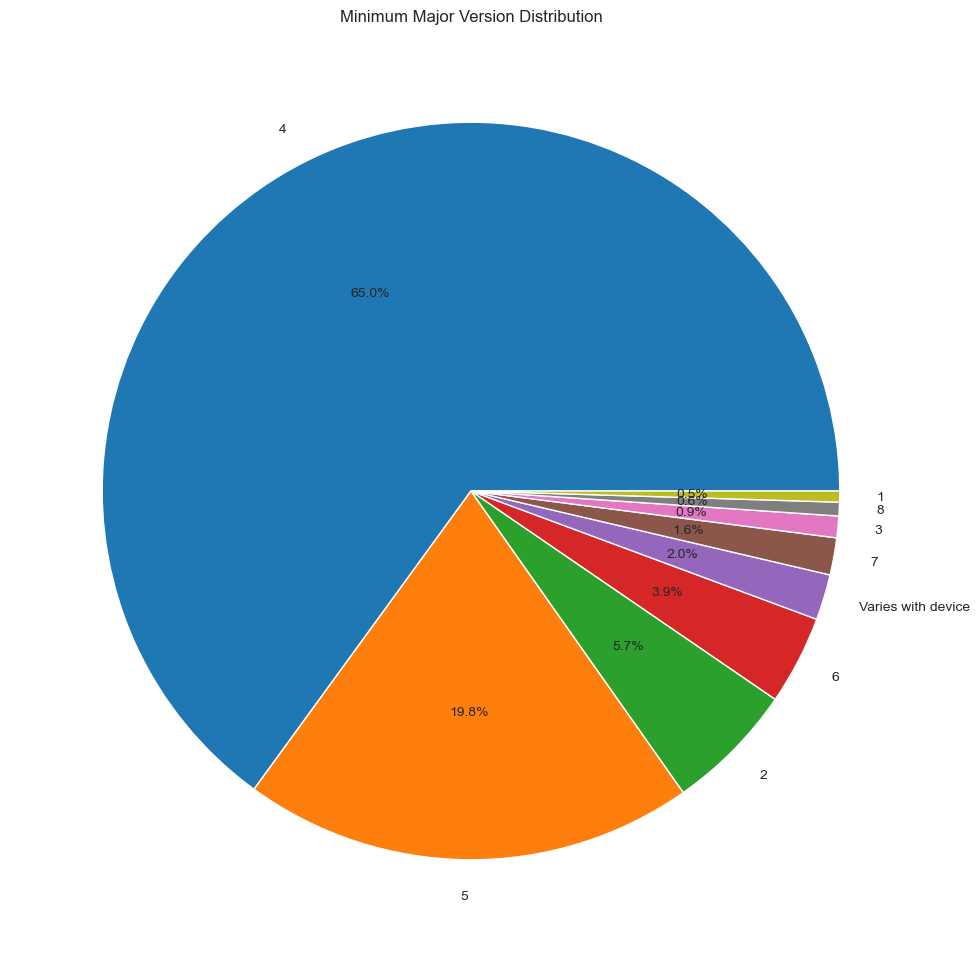

In [16]:
# Pie chart
plt.figure(figsize=(10, 10))
plt.pie(data=df['Major Version'].value_counts(), x=df['Major Version'].value_counts().values, labels=df['Major Version'].value_counts().index, autopct='%1.1f%%')
plt.title('Minimum Major Version Distribution')
plt.tight_layout()
plt.show()

/opt/homebrew/anaconda3/envs/ml/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/ml/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/ml/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/ml/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

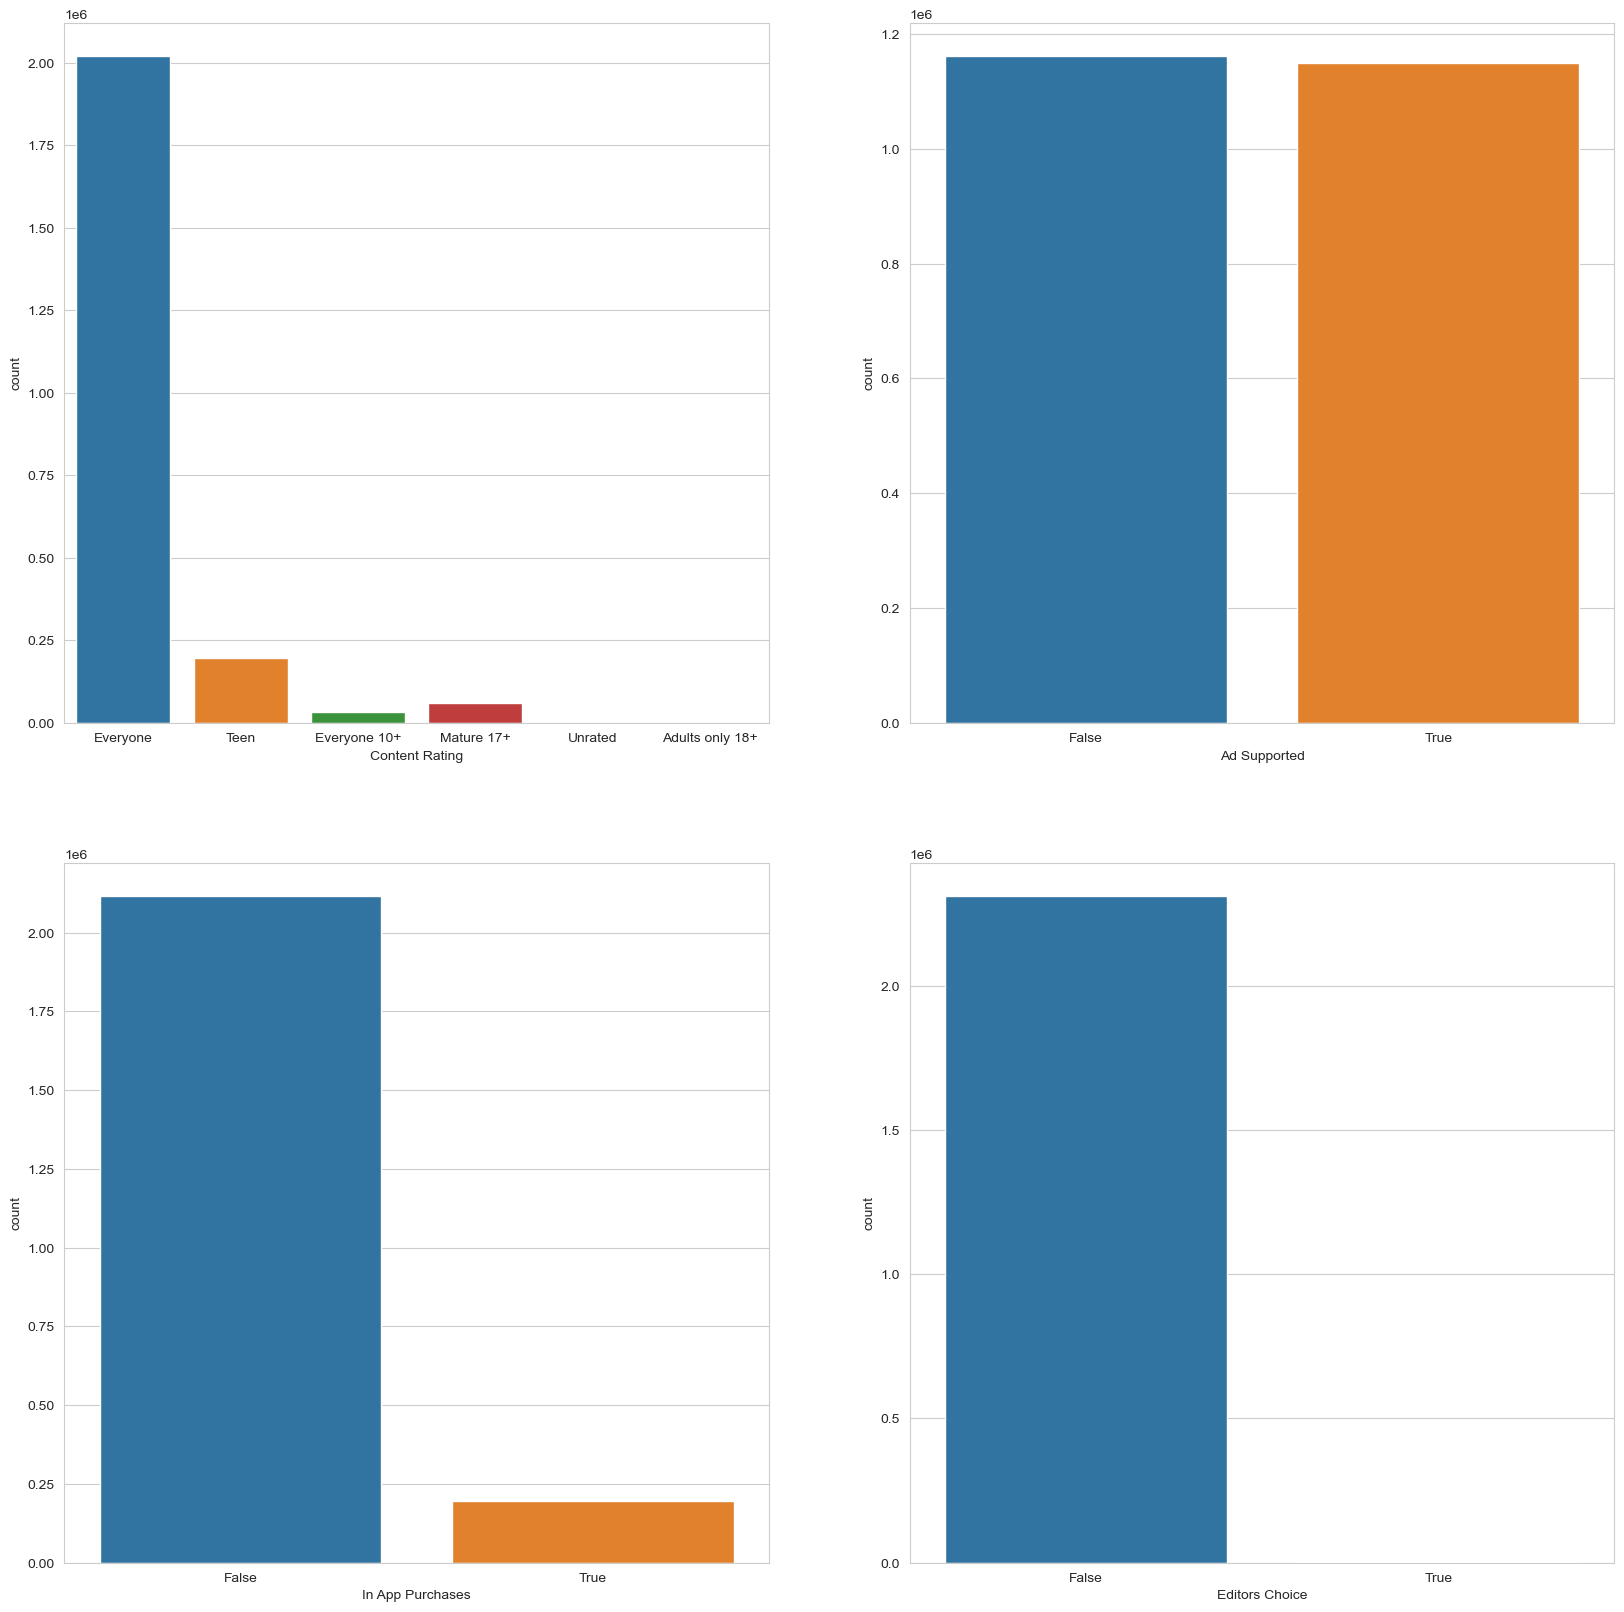

In [17]:
# Subplots for content rating, ad supported, in app purchase and editor choice distribution
import seaborn as sns
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
sns.countplot(ax=axes[0, 0], data=df, x='Content Rating')
sns.countplot(ax=axes[0, 1], data=df, x='Ad Supported')
sns.countplot(ax=axes[1, 0], data=df, x='In App Purchases')
sns.countplot(ax=axes[1, 1], data=df, x='Editors Choice')
plt.show()

In [18]:
df.shape

(2311548, 26)

In [19]:
df.drop(['App Id', 'Currency','Developer Website', 'Privacy Policy', 'Scraped Time', 'Installs','Free','Size', 'Minimum Android'], axis=1, inplace=True)

In [20]:
print(df.shape)

(2311548, 17)


In [21]:
df['Major Version'].value_counts()

Major Version
4                     1498030
5                      455874
2                      130897
6                       89878
Varies with device      46124
7                       37463
3                       21822
8                       13813
1                       11124
Name: count, dtype: int64

In [22]:
df['Minimum Installs'].value_counts()

Minimum Installs
1.000000e+02    443119
1.000000e+03    398020
1.000000e+01    299912
1.000000e+04    256663
5.000000e+02    188992
5.000000e+01    170326
5.000000e+03    143536
1.000000e+05    110233
5.000000e+04     75339
5.000000e+00     73681
1.000000e+00     65239
1.000000e+06     33644
5.000000e+05     27009
0.000000e+00     11541
5.000000e+06      6595
1.000000e+07      6191
5.000000e+07       824
1.000000e+08       549
5.000000e+08        65
1.000000e+09        55
5.000000e+09        14
1.000000e+10         1
Name: count, dtype: int64

In [23]:
def install_groupby(value):
    if value < 100000:
        return '0-100k'
    elif value < 1000000:
        return '100k-1M'
    elif value < 10000000:
        return '1M-10M'
    elif value < 100000000:
        return '10M-100M'
    else:
        return '100M+'
df['Install Group'] = df['Minimum Installs'].apply(install_groupby)

In [24]:
df['Install Group'].value_counts()

Install Group
0-100k      2126368
100k-1M      137242
1M-10M        40239
10M-100M       7015
100M+           684
Name: count, dtype: int64

In [25]:
df['Realease Date'] = pd.to_datetime(df['Released'], format='%b %d, %Y')

In [26]:
df['Last Updated'] = pd.to_datetime(df['Last Updated'], format='%b %d, %Y')

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2311548 entries, 0 to 2312943
Data columns (total 19 columns):
 #   Column            Dtype         
---  ------            -----         
 0   App Name          object        
 1   Category          object        
 2   Rating            float64       
 3   Rating Count      float64       
 4   Minimum Installs  float64       
 5   Maximum Installs  int64         
 6   Price             float64       
 7   Developer Id      object        
 8   Developer Email   object        
 9   Released          object        
 10  Last Updated      datetime64[ns]
 11  Content Rating    object        
 12  Ad Supported      bool          
 13  In App Purchases  bool          
 14  Editors Choice    bool          
 15  Clean Size        float64       
 16  Major Version     object        
 17  Install Group     object        
 18  Realease Date     datetime64[ns]
dtypes: bool(3), datetime64[ns](2), float64(5), int64(1), object(8)
memory usage: 306.4+ MB


In [28]:
df.drop(['Minimum Installs'], axis=1, inplace=True)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2311548 entries, 0 to 2312943
Data columns (total 18 columns):
 #   Column            Dtype         
---  ------            -----         
 0   App Name          object        
 1   Category          object        
 2   Rating            float64       
 3   Rating Count      float64       
 4   Maximum Installs  int64         
 5   Price             float64       
 6   Developer Id      object        
 7   Developer Email   object        
 8   Released          object        
 9   Last Updated      datetime64[ns]
 10  Content Rating    object        
 11  Ad Supported      bool          
 12  In App Purchases  bool          
 13  Editors Choice    bool          
 14  Clean Size        float64       
 15  Major Version     object        
 16  Install Group     object        
 17  Realease Date     datetime64[ns]
dtypes: bool(3), datetime64[ns](2), float64(4), int64(1), object(8)
memory usage: 288.8+ MB


In [30]:
# App name length
def app_name_length(value):
    return len(str(value))
df['App Name Length'] = df['App Name'].apply(app_name_length)

In [31]:
# Detect individual or company through developer email
# Gmail and Hotmail are individual

def detect_individual(value):
    if pd.isna(value):
        return np.nan
    if 'gmail' in value:
        return True
    else:
        return False
df['Individual'] = df['Developer Email'].apply(detect_individual)
df['Individual'].value_counts()

Individual
True     1265684
False    1045833
Name: count, dtype: int64

/opt/homebrew/anaconda3/envs/ml/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/ml/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


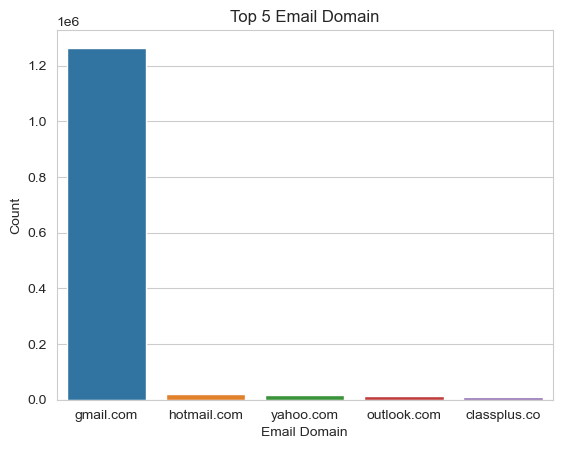

Based on the plot and analysis, there's no need to involve this feature in the model


In [32]:
# Email domain
def email_domain(value):
    if pd.isna(value):
        return np.nan
    return value.split('@')[1]
df['Email Domain'] = df['Developer Email'].apply(email_domain)
main_email_domain = df['Email Domain'].value_counts().head(5)
sns.countplot(data=df, x='Email Domain', order=main_email_domain.index)
plt.ylabel('Count')
plt.xlabel('Email Domain')
plt.title('Top 5 Email Domain')
plt.show()
print("Based on the plot and analysis, there's no need to involve this feature in the model")
df.drop(['Email Domain', 'Individual', 'Developer Email', 'Developer Id'], axis=1, inplace=True)

In [33]:
# App age
scraped_time = pd.to_datetime('2021-06-15 00:00:00')
df['App Age'] = (scraped_time - df['Realease Date']).dt.days

In [34]:
# Last update age
df['Last Update Age'] = (scraped_time - df['Last Updated']).dt.days

In [35]:
df['Content Rating'].value_counts()

Content Rating
Everyone           2020913
Teen                196224
Mature 17+           60254
Everyone 10+         33868
Unrated                154
Adults only 18+        135
Name: count, dtype: int64

In [36]:
# editor_choice = df[df['Editors Choice'] == True].copy()
# editor_choice.reset_index(drop=True, inplace=True)
# paid_apps = df[df['Price'] > 0].copy()
# paid_apps.reset_index(drop=True, inplace=True)

In [37]:
# Drop all rows with N/A values
df.dropna(inplace=True)

In [ ]:
rename_dict = {
    'App Name': 'appName',
    'Category': 'category',
    'Rating': 'rating',
    'Rating Count': 'ratingCount',
    'Maximum Installs': 'maxInstalls',
    'Price': 'priceInUSD',
    'Released': 'releasedDate',
    'Last Updated': 'lastUpdatedDate',
    'Content Rating': 'contentRating',
    'Ad Supported': 'isAdSupported',
    'In App Purchases': 'isInAppPurchases',
    'Editors Choice': 'isEditorsChoice',
    'Clean Size': 'sizeInMB',
    'Major Version': 'minMajorAndroidVersion',
    'Install Group': 'installRange',
    
}
df.rename(columns={'Clean Size': 'Size'}, inplace=True)